# Song Classification

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8)

import gc
import os
import ast
import sys
import configparser
import glob
import librosa
import librosa.display
from scipy.stats import mode

from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers.merge import concatenate
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import keras
from keras import backend as K

Using TensorFlow backend.


In [2]:
from pathlib import Path

HOME_PATH = Path.home()
MODELS_PATH = HOME_PATH / 'models'
DATA_PATH = HOME_PATH / 'data'

assert MODELS_PATH.is_dir()
assert DATA_PATH.is_dir()

In [3]:
download = False

In [4]:
if download:
    !kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

In [5]:
GTZAN_PATH = DATA_PATH / 'gtzan-music-genres'
DATASET_PATH = GTZAN_PATH / 'genres_original'

In [14]:
def load_songs(song_folder):
    song_specs = []
    idx_to_genre = []
    genre_to_idx = {}
    genres = []
    print('Loading data from %s' % song_folder)
    for genre in os.listdir(song_folder):
        genre_to_idx[genre] = len(genre_to_idx)
        idx_to_genre.append(genre)
        genre_folder = os.path.join(song_folder, genre)
        num_songs = 0
#         print('Loading %s songs...' % genre)
        for song in os.listdir(genre_folder):
            if Path(song).suffix in ['.wav']:
                try:
                    signal, sr = librosa.load(os.path.join(genre_folder, song))
                    melspec = librosa.feature.melspectrogram(signal, sr=sr).T[:1280,]
                    song_specs.append(melspec)
                    genres.append(genre_to_idx[genre])
                    num_songs += 1
                except Exception as e:
                    pass
        print('Loaded %d %s songs.' % (num_songs, genre))
        
    print(
        'Finished loading %d songs from %d genres.'
        % (len(song_specs), len(set(genres)))
    )
    
    return song_specs, genres, genre_to_idx, idx_to_genre

In [15]:
song_specs, genres, genre_to_idx, idx_to_genre = load_songs(DATASET_PATH)

Loading data from /home/mrduhart/data/gtzan-music-genres/genres_original
Loaded 100 blues songs.
Loaded 100 classical songs.
Loaded 100 country songs.
Loaded 100 disco songs.
Loaded 100 hiphop songs.
Loaded 99 jazz songs.
Loaded 100 metal songs.
Loaded 100 pop songs.
Loaded 100 reggae songs.
Loaded 100 rock songs.
Finished loading 999 songs from 10 genres.


In [16]:
song_specs[0].shape

(1280, 128)

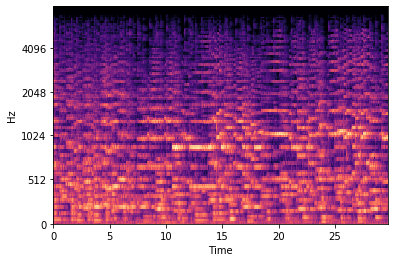

In [17]:
librosa.display.specshow(
    librosa.power_to_db(song_specs[101].T, ref=np.max),
    y_axis='mel',
    fmax=8000,
    x_axis='time'
)

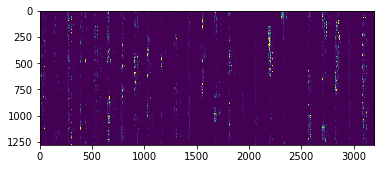

In [18]:
def show_spectogram(show_genre):
    show_genre = genre_to_idx[show_genre]
    specs = []
    for spec, genre in zip(song_specs, genres):
        if show_genre == genre:
            specs.append(spec)
            if len(specs) == 25:
                break
    if not specs:
        return 'not found!'
    x = np.concatenate(specs, axis=1)
    x = (x - x.min()) / (x.max() - x.min())
    plt.imshow((x *20).clip(0, 1.0))

show_spectogram('classical')

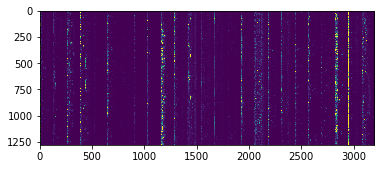

In [19]:
show_spectogram('metal')

In [20]:
def lstm_model(input_shape):
    inputs = Input(shape=input_shape, name='input')
    lstm_1 = LSTM(units=128, return_sequences=False)(inputs)
    
    dense2 = Dense(10, activation='softmax')(lstm_1)

    model = Model(inputs=[inputs], outputs=[dense2])
    sgd = keras.optimizers.SGD(lr=0.0003, momentum=0.9, decay=1e-5, nesterov=True)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

def cnn_model(input_shape):
    inputs = Input(input_shape)
    x = inputs
    levels = 64
    
    for level in range(3):
        x = Conv1D(levels, 3, activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling1D(pool_size=2, strides=2)(x)
        levels *= 2
    
    # Global Layers
    x = GlobalMaxPooling1D()(x)

    for fc in range(2):
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)

    labels = Dense(10, activation='softmax')(x)

    model = Model(inputs=[inputs], outputs=[labels])
    sgd = keras.optimizers.SGD(lr=0.0003, momentum=0.9, decay=1e-5, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

model = cnn_model((128, 128))
model.summary()

W0831 11:48:21.751699 139898666354496 deprecation_wrapper.py:119] From /mnt/d/mrduhart/code/deep_learning_cookbook/venv3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0831 11:48:22.312058 139898666354496 deprecation_wrapper.py:119] From /mnt/d/mrduhart/code/deep_learning_cookbook/venv3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0831 11:48:22.419265 139898666354496 deprecation_wrapper.py:119] From /mnt/d/mrduhart/code/deep_learning_cookbook/venv3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0831 11:48:22.901668 139898666354496 deprecation_wrapper.py:119] From /mnt/d/mrduhart/code/deep_learning_cookbook/venv3/lib/python3.6/site-packages/keras/backend/tens

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 126, 64)           24640     
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 64)           256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 63, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 61, 128)           24704     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 128)           512       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 30, 128)           0         
__________

In [21]:
def split_10(x, y):
    s = x.shape
    s = (s[0] * 10, s[1] // 10, s[2])
    return x.reshape(s), np.repeat(y, 10, axis=0)


genres_one_hot = keras.utils.to_categorical(genres, num_classes=len(genre_to_idx))

x_train, x_test, y_train, y_test = train_test_split(
    np.array(song_specs), np.array(genres_one_hot), 
    test_size=0.1, stratify=genres)

x_test, y_test = split_10(x_test, y_test)
x_train, y_train = split_10(x_train, y_train)

x_train.shape, y_train.shape

((8990, 128, 128), (8990, 10))

In [22]:
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
      min_delta=0,
      patience=3,
      verbose=0,
      mode='auto')

In [23]:
%%time

# Fit the model
history = model.fit(x_train, y_train,
      batch_size=128,
      epochs=100,
      verbose=1,
      validation_data=(x_test, y_test),
      callbacks = [earlystop])

Train on 8990 samples, validate on 1000 samples
Epoch 1/100
8990/8990 [==============================] - 7s 800us/step - loss: 2.1953 - acc: 0.2300 - val_loss: 2.0438 - val_acc: 0.2770
Epoch 2/100
8990/8990 [==============================] - 7s 806us/step - loss: 2.1044 - acc: 0.2479 - val_loss: 2.0081 - val_acc: 0.3050
Epoch 3/100
8990/8990 [==============================] - 7s 815us/step - loss: 2.0444 - acc: 0.2633 - val_loss: 1.9851 - val_acc: 0.3110
Epoch 4/100
8990/8990 [==============================] - 7s 765us/step - loss: 1.9960 - acc: 0.2763 - val_loss: 1.9580 - val_acc: 0.3260
Epoch 5/100
8990/8990 [==============================] - 7s 778us/step - loss: 1.9578 - acc: 0.2952 - val_loss: 1.9373 - val_acc: 0.3290
Epoch 6/100
8990/8990 [==============================] - 7s 796us/step - loss: 1.9184 - acc: 0.3034 - val_loss: 1.9178 - val_acc: 0.3420
Epoch 7/100
8990/8990 [==============================] - 7s 762us/step - loss: 1.8969 - acc: 0.3165 - val_loss: 1.9085 - val_acc: 

In [24]:
model.save('zoo/15/song_classify.h5')

In [25]:
def unsplit(values):
    chunks = np.split(values, 100)
    return np.array([np.argmax(chunk) % 10 for chunk in chunks])

pred_values = model.predict(x_test)
predictions = unsplit(pred_values)
truth = unsplit(y_test)
accuracy_score(predictions, truth)

0.54

In [26]:
cm = confusion_matrix(np.argmax(pred_values, axis=1), np.argmax(y_test, axis=1))
print(cm)

[[35  1  3  5  3  1  0  4  8  3]
 [ 0 69  3  3  8 12  0  0 16  3]
 [ 6 13 42  1  0  5  1  3  7  9]
 [ 0  0 16 58 10  0  7  5  6 14]
 [ 0  0  0 10 56  0  2 21 21  0]
 [10 16 10  0  0 81  0  0  9 17]
 [35  0  7 11 10  0 82  4  3 27]
 [ 1  0  2  1  5  0  0 56 14  1]
 [ 2  0  8  6  1  0  1  3 16  7]
 [11  1  9  5  7  1  7  4  0 19]]


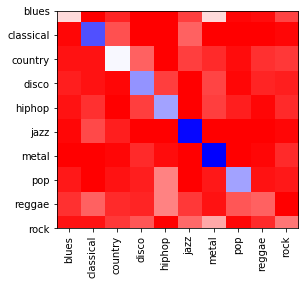

In [30]:
plt.imshow(cm.T, interpolation='nearest', cmap='bwr_r')
plt.xticks(np.arange(0, len(idx_to_genre)), idx_to_genre, rotation='vertical')
plt.yticks(np.arange(0, len(idx_to_genre)), idx_to_genre)

plt.show()

In [31]:
m1 = cnn_melspect_1D_org((128, 128))
m2 = cnn_melspect_1D((128, 128))
ac1 = 0.61 * 5
ac2 = 0
for i in range(5):
    history = m1.fit(x_train, y_train,
      batch_size=128,
      epochs=100,
      verbose=0,
      validation_data=(x_test, y_test),
      callbacks = [earlystop])
    ac1 += history.history['val_acc'][-1]
    history = m2.fit(x_train, y_train,
      batch_size=128,
      epochs=100,
      verbose=0,
      validation_data=(x_test, y_test),
      callbacks = [earlystop])
    ac2 += history.history['val_acc'][-1]

print(ac1 / 5, ac2 / 5)

NameError: name 'cnn_melspect_1D_org' is not defined